# Advanced Diabetes Prediction Using Machine Learning

## Project Overview
This project develops a comprehensive machine learning system to predict diabetes risk based on diagnostic measurements from the Pima Indians Diabetes Database. The workflow integrates advanced feature engineering, robust preprocessing, and ensemble modeling techniques.

## Dataset: Diabetes Database
Originally from the National Institute of Diabetes and Digestive and Kidney Diseases, this dataset contains diagnostic measurements from 768 female patients of Pima Indian heritage, all at least 21 years old.

## Medical Context and Features
- **Pregnancies**: Number of pregnancies (0-17)
- **Glucose**: Plasma glucose concentration in 2-hour oral glucose tolerance test (mg/dL)
  - Normal: <140 mg/dL
  - Prediabetes: 140-200 mg/dL
  - Diabetes: >200 mg/dL
- **BloodPressure**: Diastolic blood pressure (mm Hg)
  - Normal: <80
  - Stage 1 Hypertension: 80-89
  - Stage 2 Hypertension: ≥90
- **SkinThickness**: Triceps skin fold thickness (mm)
  - Normal for women: ≤18.0mm
- **Insulin**: 2-Hour serum insulin (μU/ml)
- **BMI**: Body mass index (kg/m²)
  - Underweight: <18.5
  - Normal: 18.5-24.9
  - Overweight: 25.0-29.9
  - Obese: ≥30.0
- **DiabetesPedigreeFunction**: Genetic predisposition score
- **Age**: Age in years (21-81)
- **Outcome**: Diabetes diagnosis (0: No, 1: Yes)

## Methodology
1. Comprehensive Exploratory Data Analysis with Medical Context
2. Advanced Data Preprocessing with Target-Aware Imputation
3. Medical Knowledge-Based Feature Engineering
4. Robust Scaling and Outlier Treatment
5. Ensemble Model Training with Hyperparameter Optimization
6. Comprehensive Model Evaluation and Selection
7. Production-Ready Prediction System with Risk Stratification

### Sources (Medical Context)
- American Diabetes Association (Glucose tolerance / diagnostic thresholds): https://diabetesjournals.org/care/article/44/Supplement_1/S15/30852/2-Classification-and-Diagnosis-of-Diabetes-Standards
- World Health Organization (BMI categories): https://www.who.int/data/gho/data/themes/topics/topic-details/GHO/body-mass-index
- ACC/AHA Guideline (Blood pressure classification): https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings

In [29]:
# pip install lightgbm

In [3]:
# Import comprehensive library suite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Core ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Utility libraries
from collections import Counter

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Data Loading and Initial Exploration

In [4]:
# Load dataset
data = pd.read_csv('diabetes.csv')

# Basic dataset information
print(f"Dataset shape: {data.shape}")
print(f"\nFeatures: {list(data.columns[:-1])}")
print(f"Target variable: {data.columns[-1]}")

# Display first few rows
data.head()

Dataset shape: (768, 9)

Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Target variable: Outcome


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Dataset overview and target distribution
print("Dataset Information:")
print(data.info())
print("\nTarget Distribution:")
print(data['Outcome'].value_counts())
print(f"\nClass balance ratio: {data['Outcome'].value_counts(normalize=True).round(3).to_dict()}")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

Target Distribution:
Outcome
0    500
1    268
Name: count, dtype: int64

Class balance ratio: {0: 0.651, 1: 0.349}


In [6]:
# Comprehensive statistical summary with percentiles
data.describe([0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).T

,count,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
Pregnancies,768.0,3.845052,3.369578,0.000,0.00000,1.00000,3.0000,6.00000,9.0000,10.00000,13.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,79.00000,99.00000,117.0000,140.25000,167.0000,181.00000,196.00000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,38.70000,62.00000,72.0000,80.00000,88.0000,90.00000,106.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,0.00000,23.0000,32.00000,40.0000,44.00000,51.33000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,0.00000,30.5000,127.25000,210.0000,293.00000,519.90000,846.00
BMI,768.0,31.992578,7.884160,0.000,21.80000,27.30000,32.0000,36.60000,41.5000,44.39500,50.75900,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.14035,0.24375,0.3725,0.62625,0.8786,1.13285,1.69833,2.42
Age,768.0,33.240885,11.760232,21.000,21.00000,24.00000,29.0000,41.00000,51.0000,58.00000,67.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.00000,0.0000,1.00000,1.0000,1.00000,1.00000,1.00


## 2. Advanced Exploratory Data Analysis

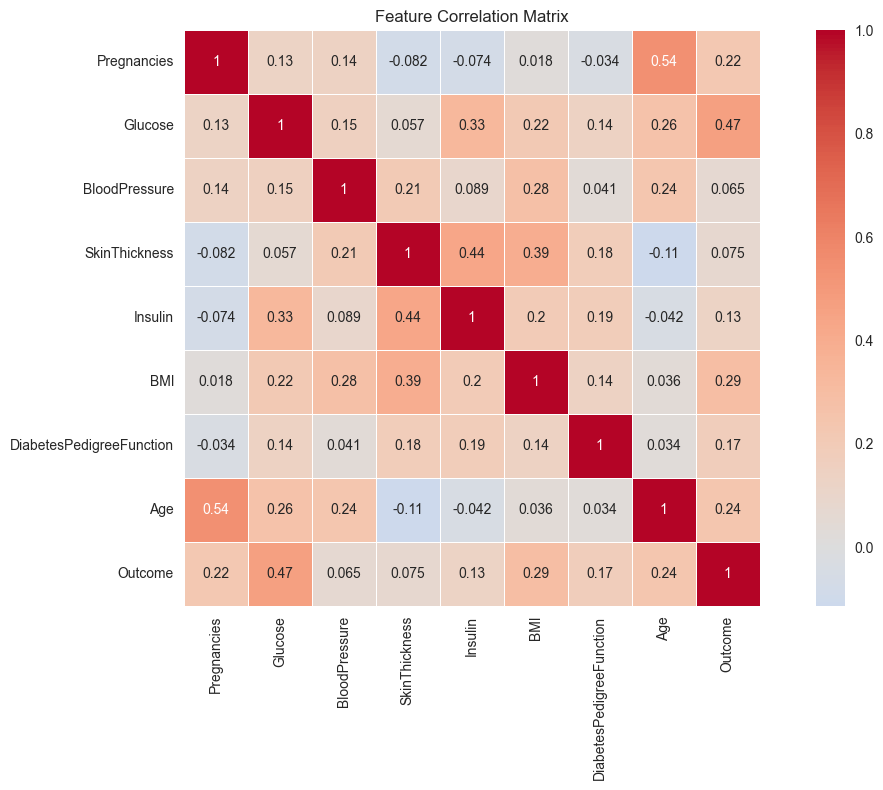

In [7]:
# Overall correlation analysis
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

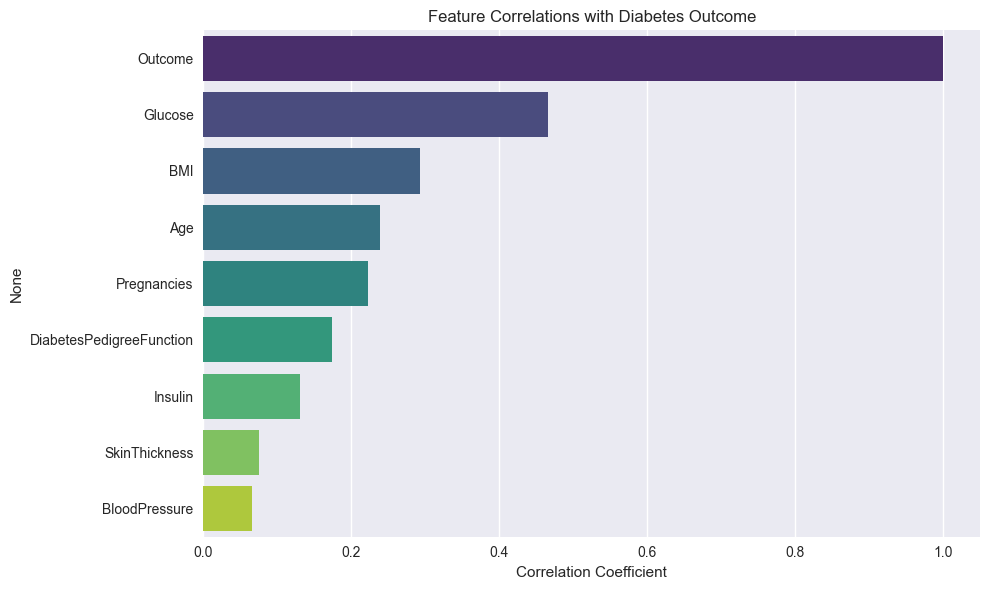

Top correlations with diabetes outcome:
Glucose                     0.467
BMI                         0.293
Age                         0.238
Pregnancies                 0.222
DiabetesPedigreeFunction    0.174
Insulin                     0.131
SkinThickness               0.075
BloodPressure               0.065
Name: Outcome, dtype: float64


In [8]:
# Target-focused correlation analysis
plt.figure(figsize=(10, 6))
target_correlations = data.corr()['Outcome'].sort_values(ascending=False)
sns.barplot(x=target_correlations.values, y=target_correlations.index, palette='viridis')
plt.title('Feature Correlations with Diabetes Outcome')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

print("Top correlations with diabetes outcome:")
print(target_correlations.drop('Outcome').round(3))

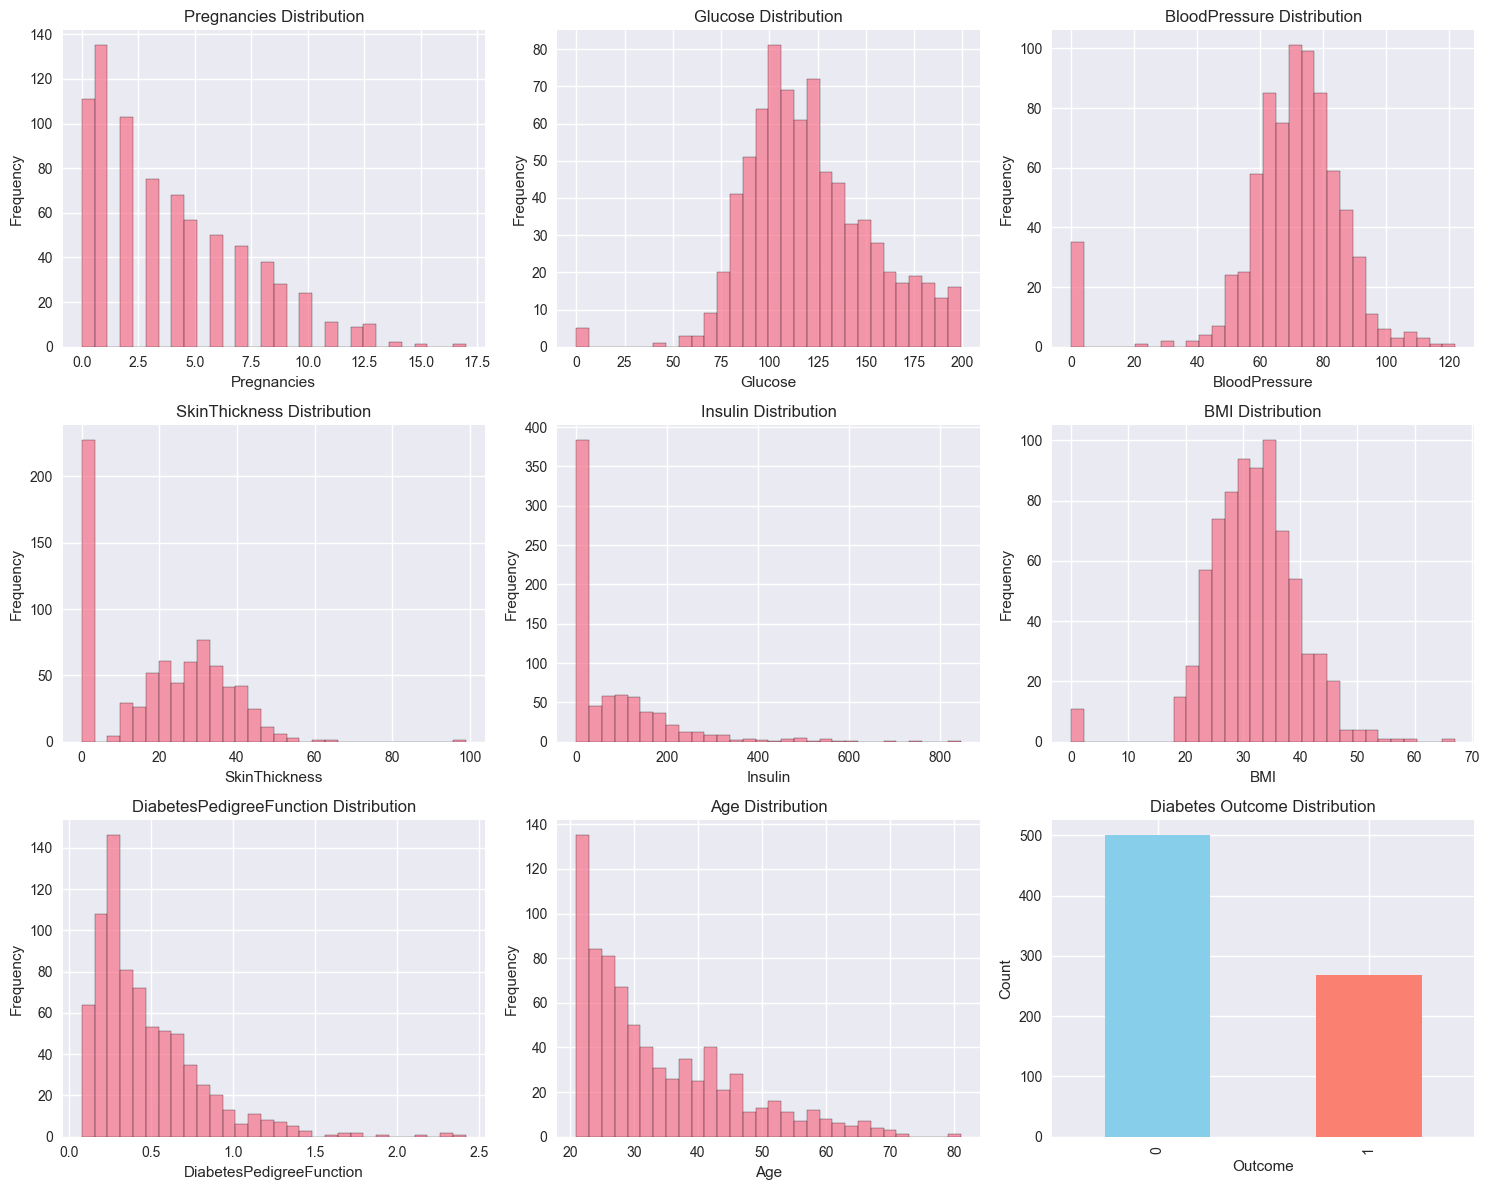

In [9]:
# Feature distribution analysis
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, column in enumerate(data.columns):
    if column != 'Outcome':
        axes[idx].hist(data[column], bins=30, alpha=0.7, edgecolor='black')
        axes[idx].set_title(f'{column} Distribution')
        axes[idx].set_xlabel(column)
        axes[idx].set_ylabel('Frequency')
    else:
        data[column].value_counts().plot(kind='bar', ax=axes[idx], color=['skyblue', 'salmon'])
        axes[idx].set_title('Diabetes Outcome Distribution')
        axes[idx].set_xlabel('Outcome')
        axes[idx].set_ylabel('Count')

plt.tight_layout()
plt.show()

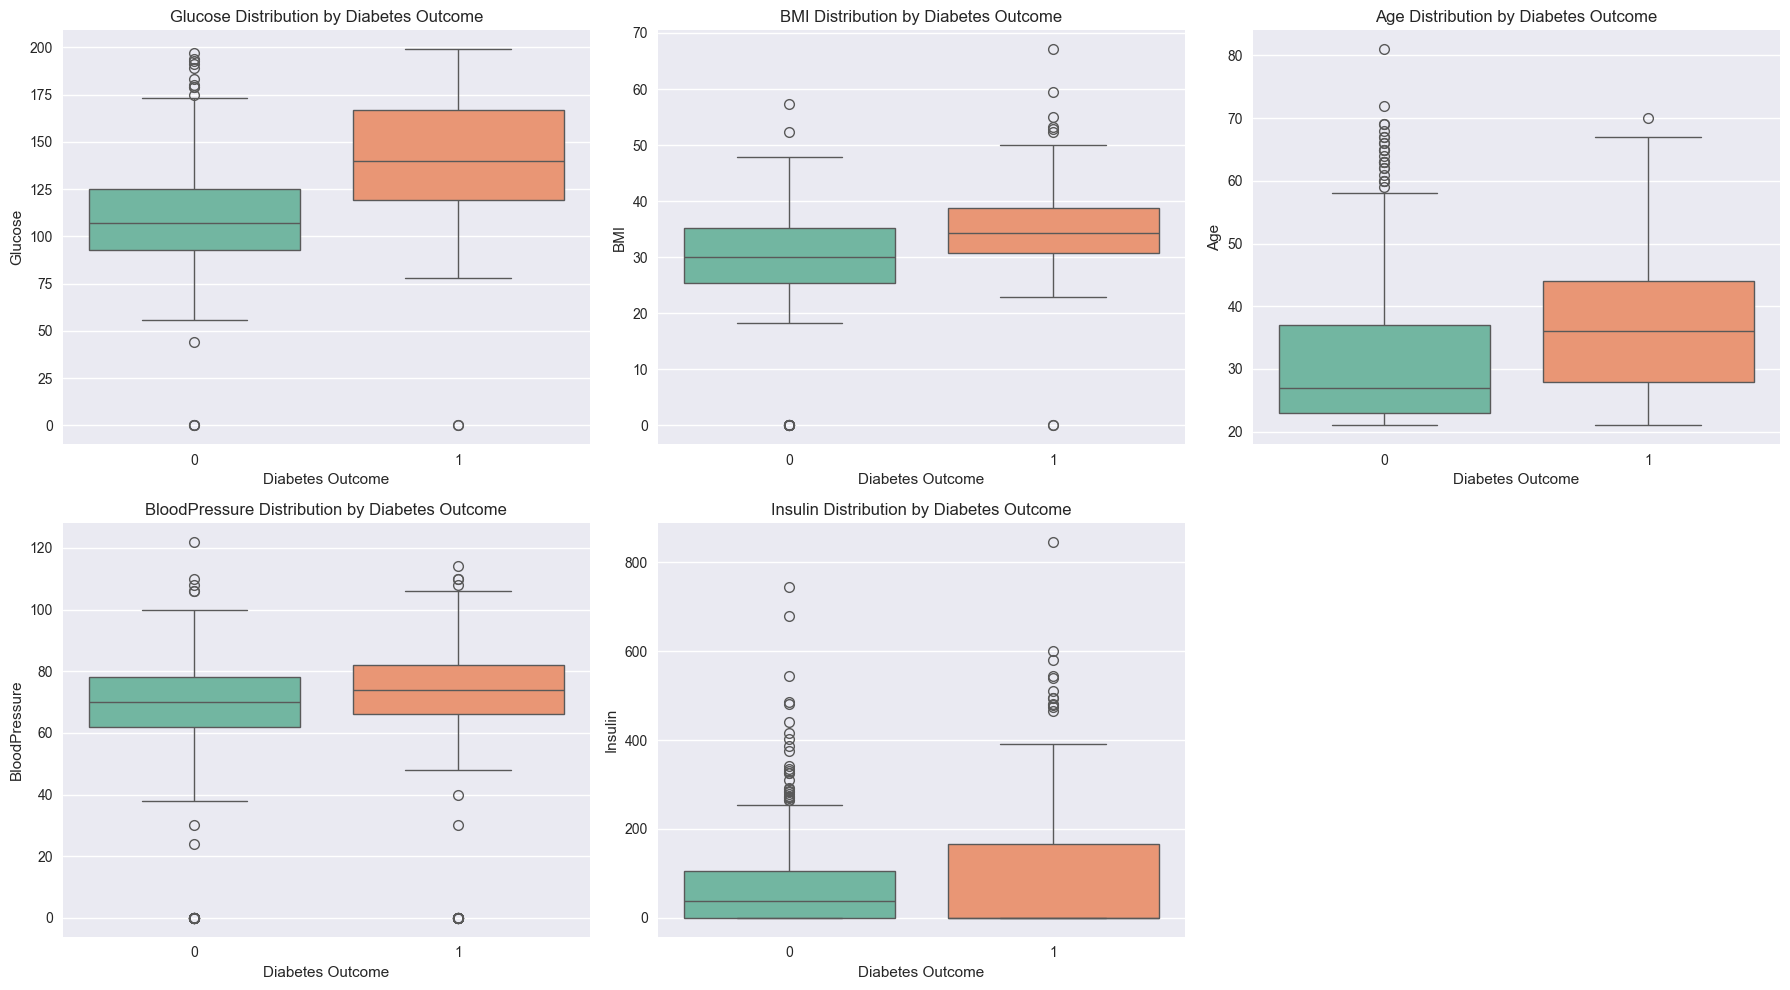

In [10]:
# Feature distributions by outcome (medical context)
features_of_interest = ['Glucose', 'BMI', 'Age', 'BloodPressure', 'Insulin']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_of_interest):
    sns.boxplot(data=data, x='Outcome', y=feature, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{feature} Distribution by Diabetes Outcome')
    axes[idx].set_xlabel('Diabetes Outcome')

# Remove empty subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

### Key Findings from EDA
- Dataset contains 768 patients with 65% non-diabetic and 35% diabetic cases
- Glucose shows strongest correlation with diabetes outcome (medical expectation confirmed)
- BMI, Age, and Pregnancies are significant predictive factors
- Several features contain zero values that require medical interpretation
- Potential outliers detected in Insulin, SkinThickness, and DiabetesPedigreeFunction

## 3. Advanced Data Preprocessing

In [11]:
# Create working copy
df = data.copy()

# Identify medically impossible zero values
# These features cannot realistically be zero in medical context
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

print("Zero values in medical measurements:")
for col in zero_columns:
    zero_count = (df[col] == 0).sum()
    zero_percentage = (zero_count / len(df)) * 100
    print(f"{col}: {zero_count} ({zero_percentage:.1f}%)")

# Replace impossible zeros with NaN
for col in zero_columns:
    df[col].replace(0, np.nan, inplace=True)

print("\nMissing values after replacing impossible zeros:")
missing_summary = df.isnull().sum()
missing_percentage = (missing_summary / len(df)) * 100
for col, count in missing_summary.items():
    if count > 0:
        print(f"{col}: {count} ({missing_percentage[col]:.1f}%)")

Zero values in medical measurements:
Glucose: 5 (0.7%)
BloodPressure: 35 (4.6%)
SkinThickness: 227 (29.6%)
Insulin: 374 (48.7%)
BMI: 11 (1.4%)

Missing values after replacing impossible zeros:
Glucose: 5 (0.7%)
BloodPressure: 35 (4.6%)
SkinThickness: 227 (29.6%)
Insulin: 374 (48.7%)
BMI: 11 (1.4%)


In [12]:
# Target-aware median imputation
# Fill missing values with median values specific to each outcome class
print("Applying target-aware median imputation...")

for col in df.columns:
    if df[col].isnull().sum() > 0:
        # Calculate median for each outcome class
        median_no_diabetes = df[df['Outcome'] == 0][col].median()
        median_diabetes = df[df['Outcome'] == 1][col].median()
        
        # Fill missing values based on outcome class
        df.loc[(df['Outcome'] == 0) & (df[col].isnull()), col] = median_no_diabetes
        df.loc[(df['Outcome'] == 1) & (df[col].isnull()), col] = median_diabetes
        
        print(f"{col}: No Diabetes median = {median_no_diabetes:.1f}, Diabetes median = {median_diabetes:.1f}")

print(f"\nMissing values after imputation: {df.isnull().sum().sum()}")

Applying target-aware median imputation...
Glucose: No Diabetes median = 107.0, Diabetes median = 140.0
BloodPressure: No Diabetes median = 70.0, Diabetes median = 74.5
SkinThickness: No Diabetes median = 27.0, Diabetes median = 32.0
Insulin: No Diabetes median = 102.5, Diabetes median = 169.5
BMI: No Diabetes median = 30.1, Diabetes median = 34.3

Missing values after imputation: 0


In [13]:
# Outlier detection and treatment using IQR method with 10th-90th percentiles
def outlier_thresholds(dataframe, variable, q1=0.10, q3=0.90):
    """Calculate outlier thresholds using specified percentiles"""
    quartile1 = dataframe[variable].quantile(q1)
    quartile3 = dataframe[variable].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outliers(dataframe, variable):
    """Check if variable has outliers"""
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    outlier_count = dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].shape[0]
    return outlier_count > 0, outlier_count

print("Outlier analysis:")
outlier_features = []
for col in df.columns:
    if col != 'Outcome':
        has_outlier, count = check_outliers(df, col)
        if has_outlier:
            print(f"{col}: {count} outliers detected")
            outlier_features.append(col)

Outlier analysis:
SkinThickness: 1 outliers detected
Insulin: 18 outliers detected
DiabetesPedigreeFunction: 4 outliers detected


In [14]:
# Apply outlier capping
def replace_with_thresholds(dataframe, variables):
    """Replace outliers with threshold values"""
    for variable in variables:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# Apply outlier treatment
replace_with_thresholds(df, outlier_features)

print("Outlier treatment completed.")
print("\nPost-treatment outlier check:")
for col in outlier_features:
    has_outlier, count = check_outliers(df, col)
    print(f"{col}: {count} outliers remaining")

Outlier treatment completed.

Post-treatment outlier check:
SkinThickness: 0 outliers remaining
Insulin: 0 outliers remaining
DiabetesPedigreeFunction: 0 outliers remaining


## 4. Medical Knowledge-Based Feature Engineering

In [15]:
# Create medical knowledge-based categorical features
print("Creating medical knowledge-based features...")

# 1. Glucose tolerance categories
df['Glucose_Category'] = pd.cut(x=df['Glucose'], 
                               bins=[0, 139, 200, float('inf')], 
                               labels=["Normal", "Prediabetes", "Diabetes"])

# 2. BMI categories
df['BMI_Category'] = pd.cut(x=df['BMI'], 
                           bins=[0, 18.5, 24.9, 29.9, float('inf')], 
                           labels=["Underweight", "Normal", "Overweight", "Obese"])

# 3. Blood pressure categories
df['BP_Category'] = pd.cut(x=df['BloodPressure'], 
                          bins=[0, 79, 89, float('inf')], 
                          labels=["Normal", "Stage1_HTN", "Stage2_HTN"])

# 4. Skin thickness binary (normal for women: ≤18mm)
df['SkinThickness_Normal'] = (df['SkinThickness'] <= 18.0).astype(int)

# 5. Age groups
df['Age_Group'] = pd.cut(x=df['Age'], 
                        bins=[0, 30, 40, 50, float('inf')], 
                        labels=["Young", "Middle_Young", "Middle_Aged", "Senior"])

# 6. Pregnancy risk categories
df['Pregnancy_Risk'] = pd.cut(x=df['Pregnancies'], 
                             bins=[-1, 0, 2, 5, float('inf')], 
                             labels=["Nulliparous", "Low_Parity", "Multi_Parity", "Grand_Multi"])

print("Medical feature categories created:")
categorical_features = ['Glucose_Category', 'BMI_Category', 'BP_Category', 
                       'Age_Group', 'Pregnancy_Risk']
for feature in categorical_features:
    print(f"\n{feature}:")
    print(df[feature].value_counts())

Creating medical knowledge-based features...
Medical feature categories created:

Glucose_Category:
Glucose_Category
Normal         569
Prediabetes    199
Diabetes         0
Name: count, dtype: int64

BMI_Category:
BMI_Category
Obese          483
Overweight     179
Normal         102
Underweight      4
Name: count, dtype: int64

BP_Category:
BP_Category
Normal        563
Stage1_HTN    145
Stage2_HTN     60
Name: count, dtype: int64

Age_Group:
Age_Group
Young           417
Middle_Young    157
Middle_Aged     113
Senior           81
Name: count, dtype: int64

Pregnancy_Risk:
Pregnancy_Risk
Low_Parity      238
Grand_Multi     219
Multi_Parity    200
Nulliparous     111
Name: count, dtype: int64


In [16]:
# One-hot encoding for categorical features
def one_hot_encoder(dataframe, categorical_columns, drop_first=True):
    """Apply one-hot encoding to categorical columns"""
    original_columns = list(dataframe.columns)
    dataframe_encoded = pd.get_dummies(dataframe, columns=categorical_columns, 
                                      drop_first=drop_first, dtype=int)
    new_columns = [col for col in dataframe_encoded.columns if col not in original_columns]
    return dataframe_encoded, new_columns

# Apply one-hot encoding
df_encoded, new_categorical_cols = one_hot_encoder(df, categorical_features)

print(f"New categorical features created: {len(new_categorical_cols)}")
print("New feature names:")
for col in new_categorical_cols:
    print(f"  - {col}")

print(f"\nTotal features after encoding: {df_encoded.shape[1]}")

New categorical features created: 13
New feature names:
  - Glucose_Category_Prediabetes
  - Glucose_Category_Diabetes
  - BMI_Category_Normal
  - BMI_Category_Overweight
  - BMI_Category_Obese
  - BP_Category_Stage1_HTN
  - BP_Category_Stage2_HTN
  - Age_Group_Middle_Young
  - Age_Group_Middle_Aged
  - Age_Group_Senior
  - Pregnancy_Risk_Low_Parity
  - Pregnancy_Risk_Multi_Parity
  - Pregnancy_Risk_Grand_Multi

Total features after encoding: 23


## 5. Robust Scaling Implementation

### Understanding Robust Scaling

**What is Robust Scaling?**

Robust scaling is a preprocessing technique that standardizes features using statistics that are resistant to outliers. Unlike standard scaling (Z-score normalization) which uses mean and standard deviation, robust scaling uses the median and interquartile range (IQR).

**Formula:**
```
Robust_Scaled_Value = (X - median(X)) / IQR(X)
```
Where IQR = Q3 (75th percentile) - Q1 (25th percentile)

**Why Use Robust Scaling?**

1. **Outlier Resistance**: The median and IQR are less affected by extreme values compared to mean and standard deviation
2. **Preserves Data Distribution**: Maintains the relative relationships between data points
3. **Medical Data Suitability**: Healthcare data often contains measurement errors and extreme biological variations
4. **Algorithm Performance**: Many ML algorithms perform better with scaled features, especially distance-based methods

**Advantages Over Standard Scaling:**

- **Standard Scaling**: Sensitive to outliers, can be skewed by extreme values
- **Robust Scaling**: Maintains feature relationships even with outliers present
- **Better for Medical Data**: Accounts for natural biological variations and measurement inconsistencies

**When to Use:**
- Dataset contains outliers that cannot be removed
- Features have different scales and units
- Using algorithms sensitive to feature magnitude (SVM, KNN, Neural Networks)
- Medical/biological data with natural variations

In [17]:
# Custom robust scaler implementation
def robust_scaler(variable):
    """Apply robust scaling using median and IQR"""
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    
    # Handle edge cases where IQR is zero
    if interquantile_range == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        
        if interquantile_range == 0:
            quartile1 = variable.quantile(0.01)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
    
    z = (variable - var_median) / interquantile_range if interquantile_range != 0 else 0
    return z.round(3)

# Identify numerical features that need scaling
binary_features = ['SkinThickness_Normal'] + new_categorical_cols
exclude_features = binary_features + ['Outcome']

numerical_features = [col for col in df_encoded.columns 
                     if col not in exclude_features and df_encoded[col].dtype in ['int64', 'float64']]

print(f"Features to be scaled: {numerical_features}")

# Apply robust scaling
df_scaled = df_encoded.copy()
for feature in numerical_features:
    df_scaled[feature] = robust_scaler(df_scaled[feature])

print("\nRobust scaling completed.")
print(f"Final dataset shape: {df_scaled.shape}")

Features to be scaled: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Robust scaling completed.
Final dataset shape: (768, 23)


### Preprocessing Summary
- Applied target-aware median imputation for missing values
- Implemented robust outlier treatment using 10th-90th percentile thresholds
- Created medical knowledge-based categorical features
- Applied one-hot encoding for categorical variables
- Implemented robust scaling resistant to outliers
- Final feature set expanded from 8 to comprehensive medical feature space

## 6. Comprehensive Model Development and Evaluation

In [18]:
# Prepare final dataset for modeling
X = df_scaled.drop('Outcome', axis=1)
y = df_scaled['Outcome']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(Counter(y_train))
print(f"Class ratio: {min(Counter(y_train).values()) / max(Counter(y_train).values()):.3f}")

Training set: 614 samples, 22 features
Test set: 154 samples

Class distribution in training set:
Counter({0: 400, 1: 214})
Class ratio: 0.535


In [19]:
# Initialize comprehensive model suite
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Support Vector Machine': SVC(random_state=42, probability=True, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# Baseline model evaluation using cross-validation
print("Baseline Model Performance (10-Fold Cross-Validation):")
print("=" * 60)

baseline_results = {}
cv_scores_all = {}

for name, model in models.items():
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    
    baseline_results[name] = cv_scores.mean()
    cv_scores_all[name] = cv_scores
    
    print(f"{name:25}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# Sort models by performance
sorted_results = sorted(baseline_results.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop performing models:")
for i, (name, score) in enumerate(sorted_results[:4], 1):
    print(f"{i}. {name}: {score:.4f}")

Baseline Model Performance (10-Fold Cross-Validation):
Logistic Regression      : 0.7885 (±0.0438)
K-Nearest Neighbors      : 0.8144 (±0.0269)
Decision Tree            : 0.8224 (±0.0398)
Random Forest            : 0.8664 (±0.0409)
Support Vector Machine   : 0.8437 (±0.0457)
XGBoost                  : 0.8713 (±0.0375)
Gradient Boosting        : 0.8664 (±0.0357)
LightGBM                 : 0.8762 (±0.0303)

Top performing models:
1. LightGBM: 0.8762
2. XGBoost: 0.8713
3. Random Forest: 0.8664
4. Gradient Boosting: 0.8664


## 7. Hyperparameter Optimization for Top Models

In [20]:
# Select top 4 models for hyperparameter tuning
top_model_names = [name for name, _ in sorted_results[:4]]
print(f"Proceeding with hyperparameter optimization for: {top_model_names}")

# Define comprehensive parameter grids
param_grids = {
    'Gradient Boosting': {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'num_leaves': [31, 50, 70],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
}

# Store optimized models
optimized_models = {}
optimization_results = {}

Proceeding with hyperparameter optimization for: ['LightGBM', 'XGBoost', 'Random Forest', 'Gradient Boosting']


In [21]:
# Hyperparameter optimization for top models
print("Starting hyperparameter optimization...")
print("=" * 50)

for model_name in top_model_names:
    if model_name in param_grids:
        print(f"\nOptimizing {model_name}...")
        
        # Get base model
        base_model = models[model_name]
        
        # Grid search with cross-validation
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grids[model_name],
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        # Store results
        optimized_models[model_name] = grid_search.best_estimator_
        optimization_results[model_name] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        
        print(f"Best CV Score: {grid_search.best_score_:.4f}")
        print(f"Best Parameters: {grid_search.best_params_}")
    else:
        # Use baseline model if no parameter grid defined
        optimized_models[model_name] = models[model_name]
        baseline_model = models[model_name].fit(X_train, y_train)
        optimization_results[model_name] = {
            'best_score': baseline_results[model_name],
            'best_params': 'Baseline parameters'
        }

print("\nHyperparameter optimization completed!")

Starting hyperparameter optimization...

Optimizing LightGBM...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best CV Score: 0.8844
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}

Optimizing XGBoost...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best CV Score: 0.8941
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}

Optimizing Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best CV Score: 0.8843
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Optimizing Gradient Boosting...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best CV Score: 0.8844
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}

Hyperparameter optimization completed!


In [22]:
# Evaluate optimized models on test set
print("Final Model Evaluation on Test Set:")
print("=" * 50)

final_results = {}
for model_name, model in optimized_models.items():
    # Fit model if not already fitted
    if not hasattr(model, 'feature_importances_') and not hasattr(model, 'coef_'):
        model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    
    final_results[model_name] = {
        'accuracy': accuracy,
        'auc': auc_score,
        'cv_score': optimization_results[model_name]['best_score']
    }
    
    print(f"{model_name:25}: Accuracy = {accuracy:.4f}, AUC = {auc_score if auc_score != 'N/A' else 'N/A':>6}")

# Select best model
best_model_name = max(final_results.keys(), key=lambda x: final_results[x]['accuracy'])
best_model = optimized_models[best_model_name]
best_accuracy = final_results[best_model_name]['accuracy']

print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {best_accuracy:.4f}")
print(f"Best Parameters: {optimization_results[best_model_name]['best_params']}")

Final Model Evaluation on Test Set:
LightGBM                 : Accuracy = 0.8701, AUC = 0.945462962962963
XGBoost                  : Accuracy = 0.8701, AUC = 0.9533333333333334
Random Forest            : Accuracy = 0.8571, AUC = 0.9328703703703703
Gradient Boosting        : Accuracy = 0.8766, AUC = 0.9535185185185185

Best Model: Gradient Boosting
Test Accuracy: 0.8766
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}


Detailed Classification Report for Gradient Boosting:
              precision    recall  f1-score   support

 No Diabetes       0.90      0.91      0.91       100
    Diabetes       0.83      0.81      0.82        54

    accuracy                           0.88       154
   macro avg       0.87      0.86      0.86       154
weighted avg       0.88      0.88      0.88       154



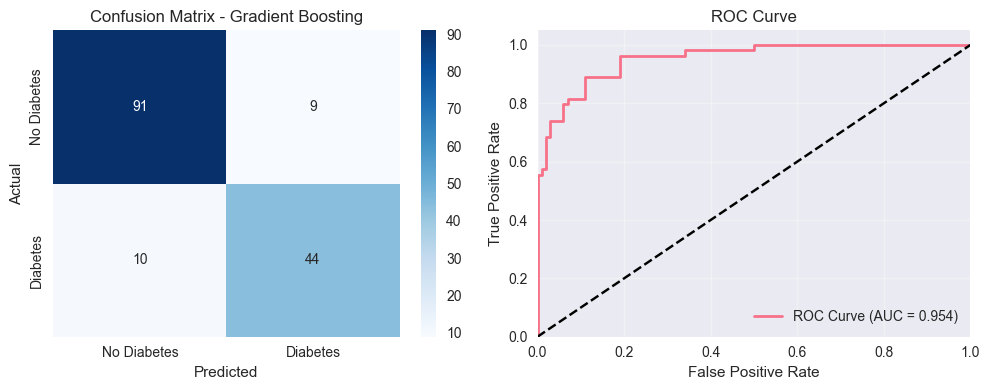

In [23]:
# Detailed evaluation of best model
y_pred_best = best_model.predict(X_test)
y_pred_proba_best = best_model.predict_proba(X_test)[:, 1]

print(f"Detailed Classification Report for {best_model_name}:")
print("=" * 60)
print(classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes']))

# Confusion Matrix Visualization
plt.figure(figsize=(10, 4))

# Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
auc_score = roc_auc_score(y_test, y_pred_proba_best)
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Enhanced Prediction System with Medical Interpretations

In [24]:
# Store preprocessing components for prediction system
feature_columns = X.columns.tolist()
original_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                    'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

print(f"Feature engineering created {len(feature_columns)} features from {len(original_features)} original features")
print(f"Feature expansion ratio: {len(feature_columns)/len(original_features):.1f}x")

Feature engineering created 22 features from 8 original features
Feature expansion ratio: 2.8x


In [25]:
def predict_diabetes_risk_enhanced(pregnancies, glucose, blood_pressure, skin_thickness, 
                                 insulin, bmi, pedigree, age, return_detailed=True):
    """
    Enhanced diabetes risk prediction with medical interpretations.
    
    Parameters:
    -----------
    pregnancies : int
        Number of pregnancies (0-17)
    glucose : float
        Plasma glucose concentration (mg/dL)
    blood_pressure : float
        Diastolic blood pressure (mm Hg)
    skin_thickness : float
        Triceps skin fold thickness (mm)
    insulin : float
        2-Hour serum insulin (μU/ml)
    bmi : float
        Body mass index (kg/m²)
    pedigree : float
        Diabetes pedigree function
    age : int
        Age in years
    return_detailed : bool
        Whether to return detailed medical interpretations
    
    Returns:
    --------
    dict
        Comprehensive prediction results with medical context
    """
    
    # Create input dataframe
    input_data = pd.DataFrame({
        'Pregnancies': [pregnancies],
        'Glucose': [glucose],
        'BloodPressure': [blood_pressure],
        'SkinThickness': [skin_thickness],
        'Insulin': [insulin],
        'BMI': [bmi],
        'DiabetesPedigreeFunction': [pedigree],
        'Age': [age]
    })
    
    # Apply the same preprocessing pipeline
    processed_data = input_data.copy()
    
    # 1. Create categorical features
    processed_data['Glucose_Category'] = pd.cut(processed_data['Glucose'], 
                                               bins=[0, 139, 200, float('inf')], 
                                               labels=["Normal", "Prediabetes", "Diabetes"])
    
    processed_data['BMI_Category'] = pd.cut(processed_data['BMI'], 
                                           bins=[0, 18.5, 24.9, 29.9, float('inf')], 
                                           labels=["Underweight", "Normal", "Overweight", "Obese"])
    
    processed_data['BP_Category'] = pd.cut(processed_data['BloodPressure'], 
                                          bins=[0, 79, 89, float('inf')], 
                                          labels=["Normal", "Stage1_HTN", "Stage2_HTN"])
    
    processed_data['SkinThickness_Normal'] = (processed_data['SkinThickness'] <= 18.0).astype(int)
    
    processed_data['Age_Group'] = pd.cut(processed_data['Age'], 
                                        bins=[0, 30, 40, 50, float('inf')], 
                                        labels=["Young", "Middle_Young", "Middle_Aged", "Senior"])
    
    processed_data['Pregnancy_Risk'] = pd.cut(processed_data['Pregnancies'], 
                                             bins=[-1, 0, 2, 5, float('inf')], 
                                             labels=["Nulliparous", "Low_Parity", "Multi_Parity", "Grand_Multi"])
    
    # 2. One-hot encoding
    categorical_features_pred = ['Glucose_Category', 'BMI_Category', 'BP_Category', 
                                'Age_Group', 'Pregnancy_Risk']
    processed_data_encoded = pd.get_dummies(processed_data, columns=categorical_features_pred, 
                                           drop_first=True, dtype=int)
    
    # 3. Robust scaling for numerical features
    numerical_features_pred = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                              'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
    
    # Use the same robust scaling approach (simplified for single prediction)
    for feature in numerical_features_pred:
        # Use population statistics from training data
        median_val = df[feature].median()
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3 - q1
        if iqr == 0:
            iqr = df[feature].quantile(0.95) - df[feature].quantile(0.05)
        processed_data_encoded[feature] = (processed_data_encoded[feature] - median_val) / iqr if iqr != 0 else 0
    
    # 4. Ensure all required columns are present
    for col in feature_columns:
        if col not in processed_data_encoded.columns:
            processed_data_encoded[col] = 0
    
    # 5. Select and reorder columns to match training data
    prediction_input = processed_data_encoded[feature_columns]
    
    # Make prediction
    prediction = best_model.predict(prediction_input)[0]
    probability = best_model.predict_proba(prediction_input)[0][1]
    
    # Create comprehensive results
    result = {
        'prediction': 'Diabetes' if prediction == 1 else 'No Diabetes',
        'probability': probability,
        'risk_level': 'High' if probability > 0.7 else 'Moderate' if probability > 0.3 else 'Low',
        'confidence': 'High' if abs(probability - 0.5) > 0.3 else 'Moderate' if abs(probability - 0.5) > 0.15 else 'Low'
    }
    
    if return_detailed:
        # Add medical interpretations
        medical_context = {
            'glucose_status': 'Normal' if glucose < 140 else 'Prediabetic' if glucose < 200 else 'Diabetic',
            'bmi_status': 'Underweight' if bmi < 18.5 else 'Normal' if bmi < 25 else 'Overweight' if bmi < 30 else 'Obese',
            'bp_status': 'Normal' if blood_pressure < 80 else 'Stage 1 HTN' if blood_pressure < 90 else 'Stage 2 HTN',
            'age_group': 'Young Adult' if age < 30 else 'Middle-aged' if age < 50 else 'Senior',
            'pregnancy_history': 'No pregnancies' if pregnancies == 0 else f'{pregnancies} pregnancies'
        }
        result['medical_context'] = medical_context
        
        # Risk factors identified
        risk_factors = []
        if glucose >= 140: risk_factors.append('Elevated glucose')
        if bmi >= 30: risk_factors.append('Obesity')
        if blood_pressure >= 90: risk_factors.append('Hypertension')
        if age >= 45: risk_factors.append('Advanced age')
        if pregnancies >= 5: risk_factors.append('High parity')
        
        result['risk_factors'] = risk_factors if risk_factors else ['No major risk factors identified']
    
    return result

In [28]:
# Test enhanced prediction system with diverse clinical scenarios
test_cases = [
    {
        'name': 'High Risk Patient - Multiple Risk Factors',
        'data': (8, 183, 95, 35, 250, 35.2, 0.672, 55),
        'description': 'Grand multiparous, prediabetic glucose, hypertensive, obese, senior'
    },
    {
        'name': 'Low Risk Patient - Healthy Profile', 
        'data': (1, 95, 65, 20, 85, 23.1, 0.167, 25),
        'description': 'Young, normal glucose, normal BP, healthy BMI'
    },
    {
        'name': 'Moderate Risk Patient - Mixed Profile',
        'data': (3, 125, 82, 28, 150, 28.5, 0.45, 38),
        'description': 'Middle-aged, borderline glucose, stage 1 HTN, overweight'
    },
    {
        'name': 'Borderline Case - Single Risk Factor',
        'data': (0, 165, 75, 22, 120, 26.8, 0.3, 29),
        'description': 'Young nulliparous with prediabetic glucose only'
    }
]

print("Enhanced Diabetes Risk Prediction System - Clinical Test Cases")
print("=" * 80)
print(f"Model Used: {best_model_name} (Test Accuracy: {best_accuracy:.1%})")
print("=" * 80)

for i, case in enumerate(test_cases, 1):
    result = predict_diabetes_risk_enhanced(*case['data'])
    
    print(f"\n{i}. {case['name']}")
    print(f"   Clinical Profile: {case['description']}")
    print(f"   Prediction: {result['prediction']}")
    print(f"   Probability: {result['probability']:.1%}")
    print(f"   Risk Level: {result['risk_level']} ({result['confidence']} confidence)")
    
    print(f"   Medical Assessment:")
    medical = result['medical_context']
    print(f"     • Glucose: {medical['glucose_status']}")
    print(f"     • BMI: {medical['bmi_status']}")
    print(f"     • Blood Pressure: {medical['bp_status']}")
    print(f"     • Age Group: {medical['age_group']}")
    print(f"     • Pregnancy History: {medical['pregnancy_history']}")
    print(f"   Risk Factors: {', '.join(result['risk_factors'])}")
    print("-" * 80)

Enhanced Diabetes Risk Prediction System - Clinical Test Cases
Model Used: Gradient Boosting (Test Accuracy: 87.7%)

1. High Risk Patient - Multiple Risk Factors
   Clinical Profile: Grand multiparous, prediabetic glucose, hypertensive, obese, senior
   Prediction: Diabetes
   Probability: 83.5%
   Risk Level: High (High confidence)
   Medical Assessment:
     • Glucose: Prediabetic
     • BMI: Obese
     • Blood Pressure: Stage 2 HTN
     • Age Group: Senior
     • Pregnancy History: 8 pregnancies
   Risk Factors: Elevated glucose, Obesity, Hypertension, Advanced age, High parity
--------------------------------------------------------------------------------

2. Low Risk Patient - Healthy Profile
   Clinical Profile: Young, normal glucose, normal BP, healthy BMI
   Prediction: No Diabetes
   Probability: 8.6%
   Risk Level: Low (High confidence)
   Medical Assessment:
     • Glucose: Normal
     • BMI: Normal
     • Blood Pressure: Normal
     • Age Group: Young Adult
     • Pregnanc